In [26]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

/tmp/ipykernel_2930/1763670448.py:9: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [27]:
# Import the Iris dataset using Seaborn
import seaborn as sns

# Load the Iris dataset
iris = sns.load_dataset('iris')

# Convert the dataset from a pandas DataFrame to a PyTorch tensor
data = torch.tensor(iris[iris.columns[0:4]].values).float()

# Transform the species labels to numerical values
labels = torch.zeros(len(data), dtype=torch.long)

# Assign numerical labels based on species
# labels[iris.species == 'setosa'] = 0  # This line isn't needed as 'setosa' already corresponds to 0
labels[iris.species == 'versicolor'] = 1  # Assign label 1 to 'versicolor'
labels[iris.species == 'virginica'] = 2   # Assign label 2 to 'virginica'


# Separate the data into DataLoaders

In [28]:
# Split the data into training and testing sets using scikit-learn
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# Convert the data and labels into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

# Create DataLoader objects for efficient batch processing
batch_size = 16

# Training DataLoader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# - DataLoader is a PyTorch utility for handling batches of data.
# - train_data contains the training samples and their corresponding labels.
# - batch_size determines the number of samples in each batch during training.
# - shuffle=True means that the data will be randomly shuffled before each epoch, which helps prevent the model from overfitting to the order of the data.

# Testing DataLoader
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
# - For testing, we typically load the entire testing dataset at once, which is equivalent to using a batch size equal to the number of testing samples.
# - test_data contains the testing samples and labels.
# - batch_size=test_data.tensors[0].shape[0] specifies that the batch size for testing should be equal to the number of testing samples, effectively loading the entire testing dataset in one batch.
# - The batch size for testing can be set this way since there's no need for batching during testing, and it simplifies the code.

# Note: You might wonder why we use DataLoader for testing with a batch size equal to the number of samples. This is a common practice in PyTorch, and it allows us to use the same testing loop structure as the training loop without modification.


# Create the model and a training regimen

In [29]:
# Define a custom neural network model class called theModelClass
class theModelClass(nn.Module):
    def __init__(self, dropoutRate):
        super().__init__()

        # Define the layers of the neural network
        self.input = nn.Linear(4, 12)  # Input layer with 4 input features and 12 output units
        self.hidden = nn.Linear(12, 12)  # Hidden layer with 12 input units and 12 output units
        self.output = nn.Linear(12, 3)  # Output layer with 12 input units and 3 output units (for classification)

        # Store the specified dropout rate as a model parameter
        self.dr = dropoutRate

    # Define the forward pass of the model
    def forward(self, x):
        # Input Layer: Pass the data through the input layer and apply ReLU activation
        x = F.relu(self.input(x))
        # x = self.input(x) # Remove ReLU

        # Apply dropout after the input layer
        x = F.dropout(x, p=self.dr, training=self.training)
        # - During training, dropout is applied to regularize the model.
        # - During evaluation (eval mode), dropout is turned off, ensuring consistent inference.

        # Hidden Layer: Pass the data through the hidden layer and apply ReLU activation
        x = F.relu(self.hidden(x))
        # x = self.hidden(x) # Remove ReLU
        
        # Apply dropout after the hidden layer
        x = F.dropout(x, p=self.dr, training=self.training)

        # Output Layer: Pass the data through the output layer (no dropout applied here)
        x = self.output(x)

        return x


In [30]:
# Create an instance of the custom neural network model class called tmpnet
# with a dropout rate of 0.25.
tmpnet = theModelClass(0.25)

# Generate random data (tmpdata) with shape (10, 4), where 10 is the number of data points
# and 4 is the number of input features. This simulates input data for testing.
tmpdata = torch.randn((10, 4))

# Pass the random data (tmpdata) through the tmpnet model to obtain predictions (yhat).
yhat = tmpnet(tmpdata)


In [31]:
# Function to create a new ANN model
def createANewModel(dropoutrate):

  # Create an instance of the custom neural network model class 'theModelClass'
  ANNiris = theModelClass(dropoutrate)

  # Define the loss function as Cross-Entropy Loss, which is suitable for classification tasks
  lossfun = nn.CrossEntropyLoss()

  # Create an optimizer for training the model. Here, we use Stochastic Gradient Descent (SGD).
  # We pass the model's parameters to the optimizer so that it knows which weights to update during training.
  # We set the learning rate to 0.005, which controls the step size in weight updates.
  optimizer = torch.optim.SGD(ANNiris.parameters(), lr=0.005)

  # Return the created model, loss function, and optimizer.
  return ANNiris, lossfun, optimizer


In [32]:
# Global parameter: Number of epochs for training
numepochs = 500

# Function to train the model
def trainTheModel():

  # Initialize lists to store training and test accuracies
  trainAcc = []
  testAcc  = []

  # Loop over epochs
  for epochi in range(numepochs):

    # Switch the model to training mode
    ANNiris.train()

    # Initialize a list to store batch accuracies
    batchAcc = []

    # Loop over training data batches
    for X, y in train_loader:

      # Forward pass and compute the loss
      yHat = ANNiris(X)  # Forward pass to obtain predictions
      loss = lossfun(yHat, y)  # Compute the loss using the specified loss function

      # Backpropagation
      optimizer.zero_grad()  # Reset gradients
      loss.backward()  # Compute gradients
      optimizer.step()  # Update model parameters

      # Compute training accuracy just for this batch
      batchAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())

    # End of batch loop...

    # Calculate the average training accuracy for this epoch
    trainAcc.append(np.mean(batchAcc))

    # Test accuracy
    ANNiris.eval()  # Switch the model to evaluation mode (dropout turned off)
    X, y = next(iter(test_loader))  # Extract a batch of test data (X, y)
    predlabels = torch.argmax(ANNiris(X), axis=1)  # Predict labels for the test data
    testAcc.append(100 * torch.mean((predlabels == y).float()).item())

  # Function output: Lists of training and test accuracies over epochs
  return trainAcc, testAcc



# Now for the real work! ;)

In [42]:
# Create a model with dropout rate set to 0.0
dropoutrate = .2
ANNiris, lossfun, optimizer = createANewModel(dropoutrate)

# Train the model
trainAcc, testAcc = trainTheModel()


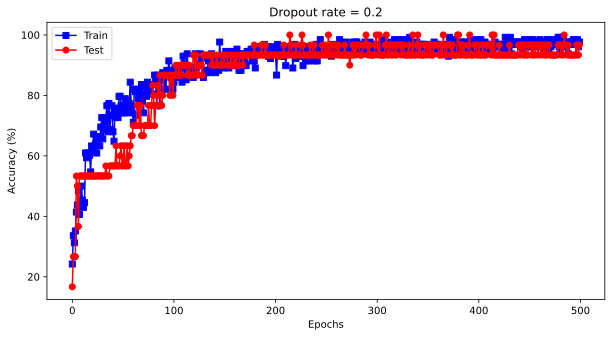

In [43]:
# Plot the results
fig = plt.figure(figsize=(10, 5))

# Plot training accuracy
plt.plot(trainAcc, 'bs-')

# Plot test accuracy
plt.plot(testAcc, 'ro-')

# Set labels for the x and y axes
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')

# Create a legend for the plot
plt.legend(['Train', 'Test'])

# Set the title of the plot, including the dropout rate value
plt.title('Dropout rate = %g' % dropoutrate)

# Display the plot
plt.show()


In [35]:
# Run an experiment

# Define a range of dropout rates from 0 to 0.9 in increments of 0.1
dropoutRates = np.arange(10)/10

# Create an array to store the results with two columns: training accuracy and test accuracy
results = np.zeros((len(dropoutRates), 2))

# Loop over different dropout rates
for di in range(len(dropoutRates)):

    # Create and train the model for the current dropout rate
    ANNiris, lossfun, optimizer = createANewModel(dropoutRates[di])
    trainAcc, testAcc = trainTheModel()

    # Store the last 50 epochs' average accuracies in the results array
    results[di, 0] = np.mean(trainAcc[-50:])
    results[di, 1] = np.mean(testAcc[-50:])


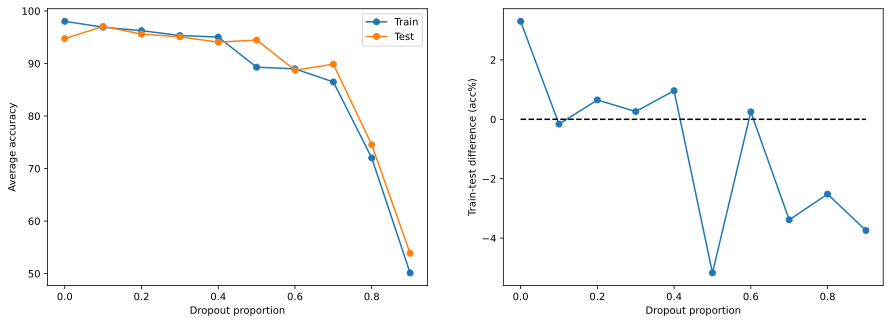

In [36]:
# Plot the experiment results
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plot average accuracy vs. dropout proportion
ax[0].plot(dropoutRates, results, 'o-')
ax[0].set_xlabel('Dropout proportion')
ax[0].set_ylabel('Average accuracy')
ax[0].legend(['Train', 'Test'])

# Plot the difference between training and test accuracy vs. dropout proportion
ax[1].plot(dropoutRates, -np.diff(results, axis=1), 'o-')
ax[1].plot([0, .9], [0, 0], 'k--')
ax[1].set_xlabel('Dropout proportion')
ax[1].set_ylabel('Train-test difference (acc%)')

# Show the plots
plt.show()


### Reflections

1. The larger dropout rate, the model need more epoches to convergence. So at the same epoches, training accuracy is worse. 
2. Train-test diff < 0 means the dropout had better effect on eliminating overfitting (because testing accurancy is better). Use early stopping technique to get the best sweetspot.
3. This dataset is so small and test set is randomly selected from all iris data, so the training set & test set are not independent, we can NOT clearly see overfitting issue on this dataset.

# Additional explorations

In [37]:
# 1) Remove the ReLU nonlinearity from the network. Does that change the effect of dropout proportion on performance?
# 
# 2) I mentioned that dropout doesn't necessarily improve performance for shallow models. What happens if you increase 
#    the complexity of this model, for example by adding several additional (and wider) hidden layers?
# 